In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyhepmc
import plotly.graph_objects as go
from DarkNews import GenLauncher

# HEPMC (and hepevt) Plotter

This notebook takes in both DarkNews and TEG HEPMC/hepevt outputs and turns them into a pandas dataframe for plotting

In [68]:
def hepmc_to_df(file):
    cols = ['Event', 'State','PDG', 'px', 'py', 'pz', 'E', 'vtx_x', 'vtx_y', 'vtx_z', 'vtx_t']
    # df_list = []  # Collect all event dataframes
    df = pd.DataFrame(columns=cols)
    with pyhepmc.open(file) as f:

        for event in f:
            event.set_units(pyhepmc.Units.MomentumUnit.GEV, pyhepmc.Units.LengthUnit.CM)
        
            # print(f"Event {event.event_number} uses units: Momentum - {units.momentum}, Length - {units.length}")
            
            status_arr, pdg_arr, px_arr, py_arr, pz_arr, E_arr, vtx_x_arr, vtx_y_arr, vtx_z_arr, vtx_t_arr = [], [], [], [], [], [], [], [], [], []

            for particle in event.particles:
                # Get the vertex that produced this particle

                status_arr.append(particle.status)
                pdg_arr.append(particle.pid)

                try: 
                    vertex = particle.end_vertex.position
                except(AttributeError):
                    vertex =  particle.production_vertex.position

                vtx_x_arr.append(vertex[0])
                vtx_y_arr.append(vertex[1])
                vtx_z_arr.append(vertex[2])
                vtx_t_arr.append(vertex[3])

                momentum = particle.momentum
                px_arr.append(momentum[0])
                py_arr.append(momentum[1])
                pz_arr.append(momentum[2])
                E_arr.append(momentum[3])

            interaction = np.array([status_arr, pdg_arr, px_arr, py_arr, pz_arr, E_arr, vtx_x_arr, vtx_y_arr, vtx_z_arr, vtx_t_arr]).T
            temp_df = pd.DataFrame(interaction, columns=cols[1:])
            temp_df.insert(0, 'Event', event.event_number)    
            df = pd.concat([df, temp_df], ignore_index=True)

    return df

def hepevt_to_df(file):
    cols = ['Event', 'State','PDG', 'px', 'py', 'pz', 'E', 'vtx_x', 'vtx_y', 'vtx_z', 'vtx_t']
    df = pd.DataFrame(columns=cols)
    with open(file, 'r') as f:
        # 1st line: event number, number of particles. Group by event number
        lines = f.readlines()
        i = 0
        while i < len(lines):
            header = lines[i].strip().split()
            event_num = int(header[0])
            num_particles = int(header[1])
            status_arr, pdg_arr, px_arr, py_arr, pz_arr, E_arr, vtx_x_arr, vtx_y_arr, vtx_z_arr, vtx_t_arr = [], [], [], [], [], [], [], [], [], []

            for j in range(num_particles):
                i += 1
                particle_data = lines[i].strip().split()
                status_arr.append(int(particle_data[0]))
                pdg_arr.append(int(particle_data[1]))
                px_arr.append(float(particle_data[6]))
                py_arr.append(float(particle_data[7]))
                pz_arr.append(float(particle_data[8]))
                E_arr.append(float(particle_data[9]))
                # Skip mass (particle_data[10])
                vtx_x_arr.append(float(particle_data[11]))
                vtx_y_arr.append(float(particle_data[12]))
                vtx_z_arr.append(float(particle_data[13]))
                vtx_t_arr.append(float(particle_data[14]))

            interaction = np.array([status_arr, pdg_arr, px_arr, py_arr, pz_arr, E_arr, vtx_x_arr, vtx_y_arr, vtx_z_arr, vtx_t_arr]).T
            temp_df = pd.DataFrame(interaction, columns=cols[1:])
            temp_df.insert(0, 'Event', event_num)    
            df = pd.concat([df, temp_df], ignore_index=True)
            i += 1
    return df

def get_opening_angle(df, pdg1, pdg2):
    angles = []
    grouped = df.groupby('Event')
    for event_num, group in grouped:
        particle1 = group[group['PDG'] == pdg1]
        particle2 = group[group['PDG'] == pdg2]
        if not particle1.empty and not particle2.empty:
            p1 = np.array([particle1.iloc[0]['px'], particle1.iloc[0]['py'], particle1.iloc[0]['pz']])
            p2 = np.array([particle2.iloc[0]['px'], particle2.iloc[0]['py'], particle2.iloc[0]['pz']])
            cos_theta = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
            angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid numerical issues
            angles.append(np.degrees(angle))  # Convert to degrees
    return angles

def get_two_body_inv_mass(df, pdg1, pdg2):
    inv_masses = []
    grouped = df.groupby('Event')
    for event_num, group in grouped:
        particle1 = group[group['PDG'] == pdg1]
        particle2 = group[group['PDG'] == pdg2]
        if not particle1.empty and not particle2.empty:
            E1 = particle1.iloc[0]['E']
            E2 = particle2.iloc[0]['E']
            p1 = np.array([particle1.iloc[0]['px'], particle1.iloc[0]['py'], particle1.iloc[0]['pz']])
            p2 = np.array([particle2.iloc[0]['px'], particle2.iloc[0]['py'], particle2.iloc[0]['pz']])
            total_E = E1 + E2
            total_p = p1 + p2
            inv_mass = np.sqrt(total_E**2 - np.dot(total_p, total_p))
            inv_masses.append(inv_mass)
    return inv_masses

def get_lead_shower_energy(df):
    shower_energy = []
    grouped = df.groupby('Event')
    for event_num, group in grouped:
        group = group[group['PDG'].abs() == 11] # e+ or e-
        if len(group) > 1:
            group = group.iloc[group['E'].argmax()]
        elif len(group) == 0:
            continue

        shower_energy.append(group['E'])
    return shower_energy

In [69]:
make_new_dn = False
mzprime = 0.15
m4 = 0.6

kwargs = {  
        'neval': 1e3,
        'HNLtype': 'dirac',
        # 'hepmc3': True,
        'hepevt': True,
        'unweighted_hep_events': 100,
        # 'hep_unweight': True,
        'experiment': 'microboone',
        'nopelastic': True,
        'pandas': False,
        'loglevel': 'WARNING'
        }

if make_new_dn:
    gen_object = GenLauncher(mzprime=mzprime, m4=m4,**kwargs)
    gen_object.run(overwrite_path='./outputs/')
    dn_df = gen_object.df

In [70]:
file = 'outputs/numu_epem_5000.hepmc' # Large TEG sample
trident_epem = hepmc_to_df(file)

file = 'outputs/numu_numi_5000.hepevt' # Large TEG sample
trident_numi = hepevt_to_df(file)

file = 'outputs/hep_ascii.hepmc3'
dn_epem = hepmc_to_df(file)

file = 'outputs/0.001_0.1_epem.hepmc' # Le-Lmu sample, mzprime=0.1 GeV, gprime=0.001
lelmu_epem = hepmc_to_df(file)

/tmp/ipykernel_2492396/792448557.py:39: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/tmp/ipykernel_2492396/792448557.py:74: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/tmp/ipykernel_2492396/792448557.py:39: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat oper

In [71]:
trident_angles = get_opening_angle(trident_epem, 11, -11)
numi_angles = get_opening_angle(trident_numi, 11, -11)
dn_angles = get_opening_angle(dn_epem, 11, -11)
lelmu_angles = get_opening_angle(lelmu_epem, 11, -11)

trident_inv_masses = get_two_body_inv_mass(trident_epem, 11, -11)
numi_inv_masses = get_two_body_inv_mass(trident_numi, 11, -11)
dn_inv_masses = get_two_body_inv_mass(dn_epem, 11, -11)
lelmu_inv_masses = get_two_body_inv_mass(lelmu_epem, 11, -11)

# Opening Angle

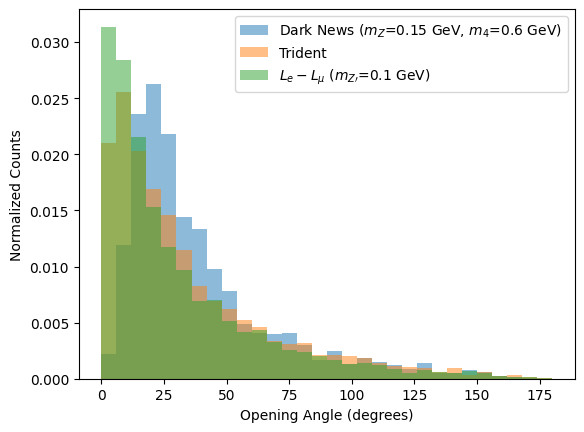

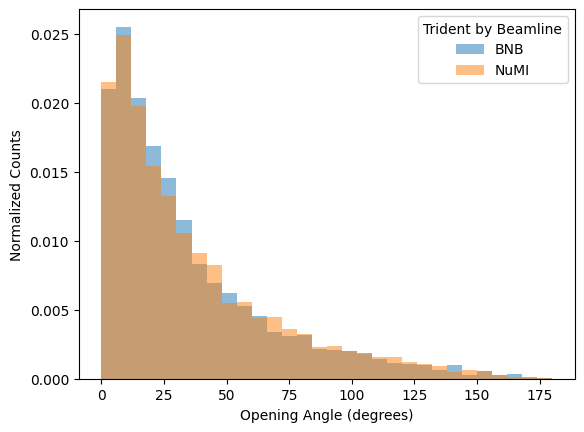

In [72]:
bins = np.linspace(0, 180, 31)
plt.hist(dn_angles, bins=bins, alpha=0.5, density=True, label=r'Dark News ($m_Z$=0.15 GeV, $m_4$=0.6 GeV)')
plt.hist(trident_angles, bins=bins, alpha=0.5, density=True, label='Trident')
plt.hist(lelmu_angles, bins=bins, alpha=0.5, density=True, label=r'$L_e-L_\mu$ ($m_{Z\prime}$=0.1 GeV)')

plt.legend()
plt.xlabel('Opening Angle (degrees)')
plt.ylabel('Normalized Counts')
# plt.title('Comparison of e+e- Opening Angles')
plt.show()

bins = np.linspace(0, 180, 31)
plt.hist(trident_angles, bins=bins, alpha=0.5, density=True, label='BNB')
plt.hist(numi_angles, bins=bins, alpha=0.5, density=True, label=r'NuMI')

plt.legend(title='Trident by Beamline')
plt.xlabel('Opening Angle (degrees)')
plt.ylabel('Normalized Counts')
# plt.title('Comparison of e+e- Opening Angles')
plt.show()

# Invariant Mass

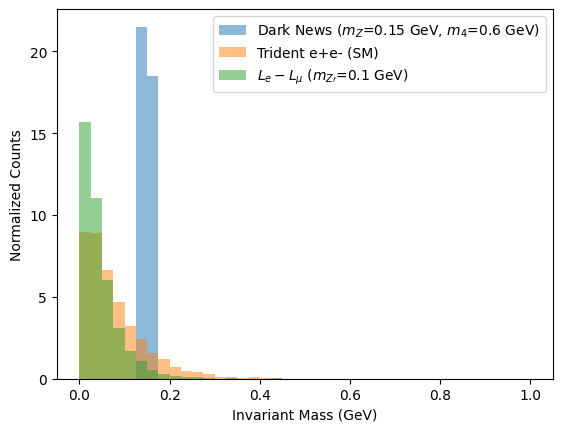

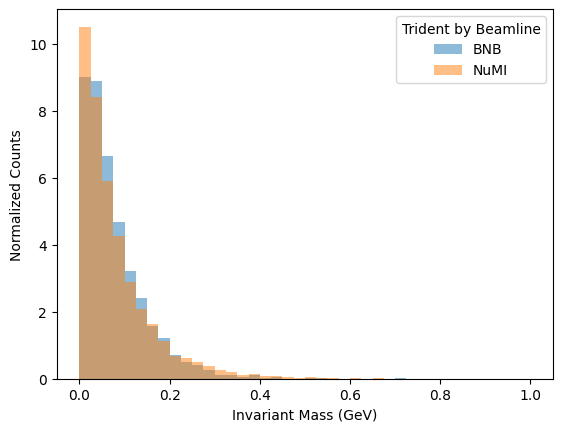

In [73]:
bins = np.linspace(0, 1, 41)
plt.hist(dn_inv_masses, bins=bins, alpha=0.5, density=True, label=r'Dark News ($m_Z$=0.15 GeV, $m_4$=0.6 GeV)')
plt.hist(trident_inv_masses, bins=bins, alpha=0.5, density=True, label='Trident e+e- (SM)')
plt.hist(lelmu_inv_masses, bins=bins, alpha=0.5, density=True, label=r'$L_e-L_\mu$ ($m_{Z\prime}$=0.1 GeV)')
plt.legend()
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Normalized Counts')
plt.show()

plt.hist(trident_inv_masses, bins=bins, alpha=0.5, density=True, label='BNB')
plt.hist(numi_inv_masses, bins=bins, alpha=0.5, density=True, label=r'NuMI')
plt.legend(title='Trident by Beamline')
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Normalized Counts')
plt.show()

# Lead Shower Energy

In [74]:
trident_shower_energy = get_lead_shower_energy(trident_epem)
numi_shower_energy = get_lead_shower_energy(trident_numi)
dn_shower_energy = get_lead_shower_energy(dn_epem)

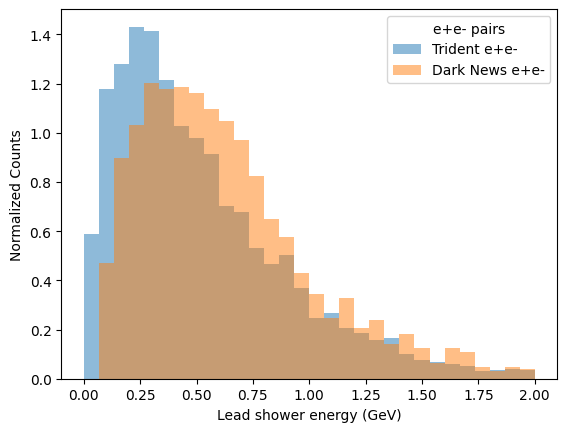

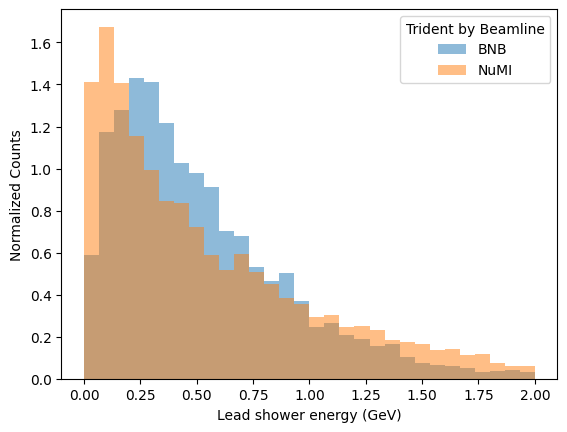

In [75]:
bins = np.linspace(0, 2, 31)
plt.hist(trident_shower_energy, bins=bins, alpha=0.5, density=True, label='Trident e+e-')
plt.hist(dn_shower_energy, bins=bins, alpha=0.5, density=True, label='Dark News e+e-')
plt.legend(title='e+e- pairs')
plt.xlabel('Lead shower energy (GeV)')
plt.ylabel('Normalized Counts')
plt.show()

plt.hist(trident_shower_energy, bins=bins, alpha=0.5, density=True, label='BNB')
plt.hist(numi_shower_energy, bins=bins, alpha=0.5, density=True, label='NuMI')
plt.legend(title='Trident by Beamline')
plt.xlabel('Lead shower energy (GeV)')
plt.ylabel('Normalized Counts')
plt.show()

# 2D Momentum Distributions

In [76]:
    
def get_shower_pair_energies(df):
    query = 'State == 1 & (PDG == 11 | PDG == -11)'

    df.query(query).groupby('Event')

    shower_energy_pairs = []

    for event_no, group in df.query(query).groupby('Event'):
        showers = group['E'].sort_values().values
        shower_energy_pairs.append(showers)
    return np.array(shower_energy_pairs)

trident_showers = get_shower_pair_energies(trident_epem)
dn_showers = get_shower_pair_energies(dn_epem)
numi_showers = get_shower_pair_energies(trident_numi)
bsm_showers = get_shower_pair_energies(lelmu_epem)


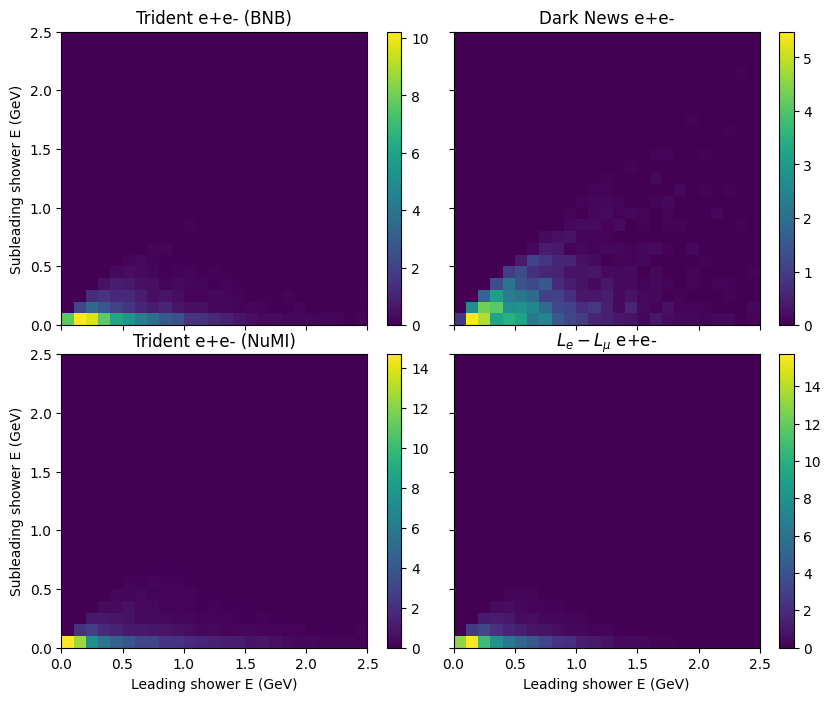

In [77]:


E_bins = np.linspace(0, 2.5, 26)
fig, ax = plt.subplots(2,2,  sharex=True, sharey=True,figsize = (10,8))

#Adjust the subplot parameters to add white space

plt.sca(ax[0][0])
arr = trident_showers
plt.hist2d(arr[:,1], arr[:,0], density=True, bins=E_bins)
plt.ylabel('Subleading shower E (GeV)')
# plt.xlabel('Leading shower E (GeV)')
plt.colorbar()
plt.title('Trident e+e- (BNB)')

plt.sca(ax[0][1])
arr = dn_showers
plt.hist2d(arr[:,1], arr[:,0], density=True, bins=E_bins)
# plt.ylabel('Subleading shower E (GeV)')
# plt.xlabel('Leading shower E (GeV)')
plt.colorbar()
plt.title('Dark News e+e-')

plt.sca(ax[1][0])
arr = numi_showers
plt.hist2d(arr[:,1], arr[:,0], density=True, bins=E_bins)
plt.ylabel('Subleading shower E (GeV)')
plt.xlabel('Leading shower E (GeV)')
plt.colorbar()
plt.title('Trident e+e- (NuMI)')

plt.sca(ax[1][1])
arr = bsm_showers
plt.hist2d(arr[:,1], arr[:,0], density=True, bins=E_bins)
# plt.ylabel('Subleading shower E (GeV)')
plt.xlabel('Leading shower E (GeV)')
plt.colorbar()
plt.title(r'$L_e-L_\mu$ e+e-')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.025, hspace=0.1)
plt.show()


# Vertex location

In [79]:
file = 'outputs/numu_epem_500_cryo.hepmc' # Large TEG sample
trident_epem = hepevt_to_df('outputs/numu_epem_5000.hepevt') # hepmc_to_df(file)

file = 'outputs/hep_ascii.hepmc3'
dn_epem = hepmc_to_df(file)

file = 'outputs/0.001_0.1_epem.hepmc' # Le-Lmu sample, mzprime=0.1 GeV, gprime=0.001
lelmu_epem = hepmc_to_df(file)

/tmp/ipykernel_2492396/792448557.py:74: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/tmp/ipykernel_2492396/792448557.py:39: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/tmp/ipykernel_2492396/792448557.py:39: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat oper

In [80]:
color_dict = {
    11: 'blue',
    13: 'green',
    1000180400: 'purple',
    14: 'orange'
}

In [83]:
def plot_event(event):
    initial_state = event.query('State == 3')
    final_state = event.query('State == 1')


    fig = go.Figure()

    px_tot, py_tot, pz_tot, E_tot = 0, 0, 0, 0
    for _, particle in initial_state.iterrows():
        px, py, pz, E = particle['px'], particle['py'], particle['pz'], particle['E']
        vtx_x, vtx_y, vtx_z, vtx_t = particle['vtx_x'], particle['vtx_y'], particle['vtx_z'], particle['vtx_t']

        color = color_dict.get(np.abs(particle['PDG']), 'black')

        if (px != 0 or py != 0 or pz != 0):
            fig.add_trace(go.Scatter3d(
                x=[vtx_x, vtx_x-px],
                y=[vtx_z, vtx_z-pz],
                z=[vtx_y, vtx_y-py],
                mode='lines',
                line=dict(width=2, color=color),
                name=f'PDG: {particle["PDG"]}, E: {E:.2f} GeV'
            ))

        else:
            fig.add_trace(go.Scatter3d(
                x=[vtx_x],
                y=[vtx_z],
                z=[vtx_y],
                mode='markers',
                marker=dict(size=5, color=color),
                name=f'PDG: {particle["PDG"]}, E: {E:.2f} GeV'
            ))
        px_tot += px
        py_tot += py
        pz_tot += pz
        E_tot += E

    # fig.update_scenes(aspectmode='data')
    fig.show()
    print(f'Total Momentum: ({px_tot:.4f}, {py_tot:.4f}, {pz_tot:.4f}) GeV')
    print(f'Total Energy: {E_tot:.4f} GeV')

    fig = go.Figure()

    px_tot, py_tot, pz_tot, E_tot = 0, 0, 0, 0
    for _, particle in final_state.iterrows():
        px, py, pz, E = particle['px'], particle['py'], particle['pz'], particle['E']
        vtx_x, vtx_y, vtx_z, vtx_t = particle['vtx_x'], particle['vtx_y'], particle['vtx_z'], particle['vtx_t']

        color = color_dict.get(np.abs(particle['PDG']), 'black')

        fig.add_trace(go.Scatter3d(
            x=[vtx_x, vtx_x+px],
            y=[vtx_z, vtx_z+pz],
            z=[vtx_y, vtx_y+py],
            mode='lines',
            line=dict(width=2, color=color),
            name=f'PDG: {particle["PDG"]}, E: {E:.2f} GeV'
        ))
        px_tot += px
        py_tot += py
        pz_tot += pz
        E_tot += E

    # fig.update_scenes(aspectmode='data')
    fig.show()

    print(f'Total Momentum: ({px_tot:.4f}, {py_tot:.4f}, {pz_tot:.4f}) GeV')
    print(f'Total Energy: {E_tot:.4f} GeV')

event_no = 1
df = trident_numi.copy(deep=True)

event = df.groupby('Event').get_group(event_no)

plot_event(event)   


Total Momentum: (0.1820, 0.0200, 0.3502) GeV
Total Energy: 37.6086 GeV


Total Momentum: (0.1820, 0.0200, 0.3502) GeV
Total Energy: 37.6086 GeV


In [84]:
cage_height = 2.325 # m
cage_width = 2.560  # m
cage_length = 10.368  # m

vertices = []
for event in df.groupby('Event'):
    fs = event[1].query('State == 1 & PDG == 11')
    if fs.empty:
        continue
    vtx = fs[['vtx_x', 'vtx_y', 'vtx_z']].values[0]
    vertices.append(vtx)
vertices = np.array(vertices)

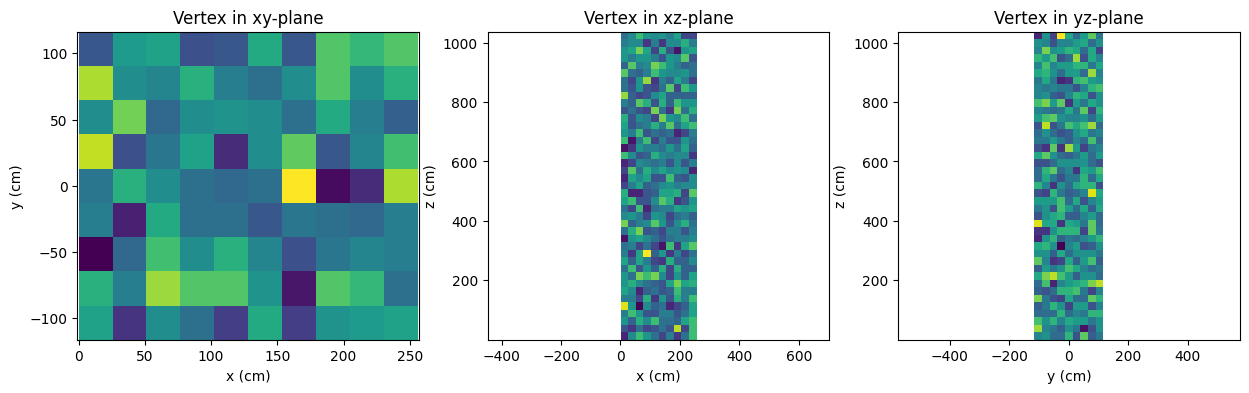

In [85]:
# xz projection
cm_per_bin = 25 # cm
x_range = cage_width
y_range = cage_height
z_range = cage_length


n_bins_x = int((x_range * 100) / cm_per_bin)
n_bins_y = int((y_range * 100) / cm_per_bin)
n_bins_z = int((z_range * 100) / cm_per_bin)

fig, ax = plt.subplots(1,3,  sharex=False, sharey=False,figsize = (15,4))

plt.sca(ax[0])
plt.hist2d(vertices[:,0], vertices[:,1], bins=[n_bins_x, n_bins_y])
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.title('Vertex in xy-plane')
# plt.colorbar(label='Counts')
plt.axis('equal')

plt.sca(ax[1])
plt.hist2d(vertices[:,0], vertices[:,2], bins=[n_bins_x, n_bins_z])
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.title('Vertex in xz-plane')
# plt.colorbar(label='Counts')
plt.axis('equal')

plt.sca(ax[2])
plt.hist2d(vertices[:,1], vertices[:,2], bins=[n_bins_y, n_bins_z])
plt.xlabel('y (cm)')
plt.ylabel('z (cm)')
plt.title('Vertex in yz-plane')
# plt.colorbar(label='Counts')
plt.axis('equal')
plt.show()

# Tangent - E vs Z

To get a better momentum vector, we should sample our production z vertex based on energy using a 2D E-z histogram

In [96]:
import uproot

nu_flavour = 'numu'
flux_file = 'data/flux/bnb/MCC9_FluxHist_volTPCActive_w2D_hists.root'
flux_file = uproot.open(flux_file)

E_z_th2d = flux_file[f'hE_vs_z_{nu_flavour}']
bins_E = E_z_th2d.axis(0).edges() # GeV
bins_z = E_z_th2d.axis(1).edges() # cm
EvsZ = E_z_th2d.values() # N per per cm per POT

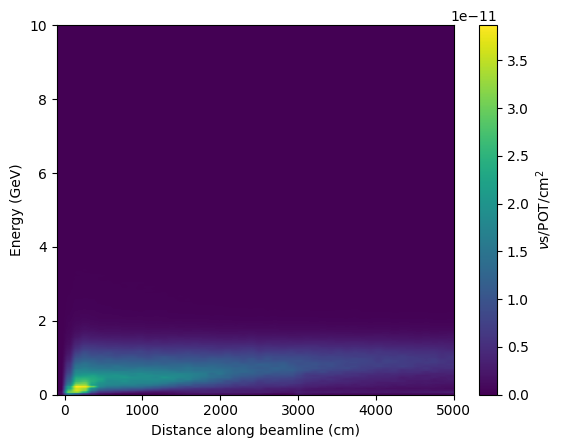

In [97]:
plt.imshow(EvsZ, extent=[bins_z[0], bins_z[-1], bins_E[0], bins_E[-1]], aspect='auto', origin='lower')
plt.xlabel('Distance along beamline (cm)')
plt.ylabel('Energy (GeV)')
plt.colorbar(label=r'$\nu$s/POT/cm$^2$')
plt.show()

In [98]:
BNB_e_vs_z_dist = EvsZ
BNB_distances_nu = bins_z[:-1] # np.diff(bins_z)/2
BNB_energy_nu_bins = bins_E
energy_nu_bin_centers = np.diff(BNB_energy_nu_bins)/2 + BNB_energy_nu_bins[:-1]

n_ebins = len(BNB_energy_nu_bins) - 1

probs_E = EvsZ.sum(axis=1)
E_nu = np.array([np.random.choice(energy_nu_bin_centers, size=1000, p=probs_E / probs_E.sum())[0] for i in range(100000)])
# E_nu = trident_epem.groupby('Event').first()['E'].values
# E_nu = trident_epem.query('State == 4 & PDG != 1000180400')['E'].values

In [94]:
e_bins = np.searchsorted(BNB_energy_nu_bins, E_nu, side='right')-1

if (n_ebins in e_bins):
        print('Some neutrino energies are above the max energy bin, setting to max bin')
        mask = e_bins >= n_ebins
        e_bins[mask] = n_ebins - 1

probs_distance = np.ones_like(BNB_e_vs_z_dist)
for i in range(len(probs_distance)):
        if BNB_e_vs_z_dist[e_bins[i],:].sum() != 0:
                probs_distance[i] = BNB_e_vs_z_dist[e_bins[i],:]

origin = np.array([np.random.choice(BNB_distances_nu, 1, p=probs_distance[e_bins[i]] / probs_distance[e_bins[i]].sum())[0] for i in range(len(e_bins))])



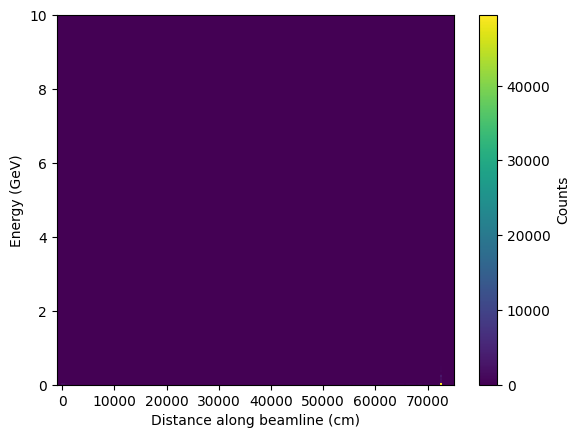

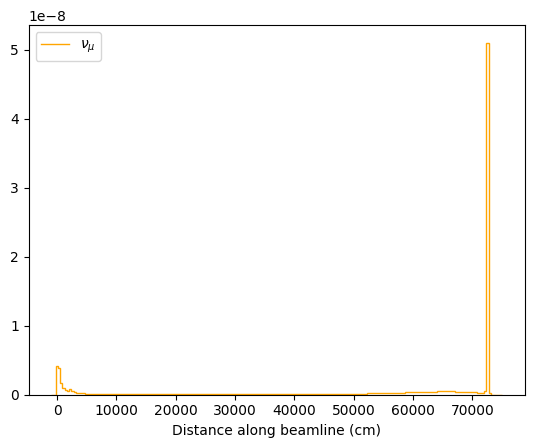

In [95]:
plt.hist2d(origin, E_nu, bins=[bins_z, bins_E])
plt.xlabel('Distance along beamline (cm)')
plt.ylabel('Energy (GeV)')
plt.colorbar(label='Counts')
plt.show()


origin_hist, _ = np.histogram(origin, bins=bins_z, density=False)
max_origin_hist = np.max(origin_hist)


# plt.stairs(origin_hist, bins_z, label='Simulated Origin', color='blue', alpha=0.7)
plt.stairs(np.sum(EvsZ, axis=0), bins_z, label=r'$\nu_\mu$', color='orange')
# plt.yscale('log')
plt.xlabel('Distance along beamline (cm)')
plt.legend()
plt.show()


# Production Vertex

In [99]:
numi_to_uboone_matrix = np.array([
    [0.9210385380402568, 0.0227135048039241207, 0.38880857519374290],
    [0.0000462540012621546684, 0.99829162468141475, -0.0584279894529063024],
    [-0.38947144863934974, 0.0538324139386641073, 0.91946400794392302]
    ])

ub_to_numi_matrix = np.linalg.inv(numi_to_uboone_matrix) 
uboone_in_numi = np.array([ 5502.0, 7259.0,  67270.0])  # cm

In [102]:
numi_epem = hepevt_to_df('outputs/numu_numi_5000.hepevt') # hepmc_to_df(file)

parent_nu = numi_epem.query('State == 3 & PDG != 1000180400') # Get the incoming neutrino

parent_vtx = parent_nu[['vtx_x', 'vtx_y', 'vtx_z']].values
parent_p = parent_nu[['px', 'py', 'pz']].values

/tmp/ipykernel_2492396/792448557.py:74: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



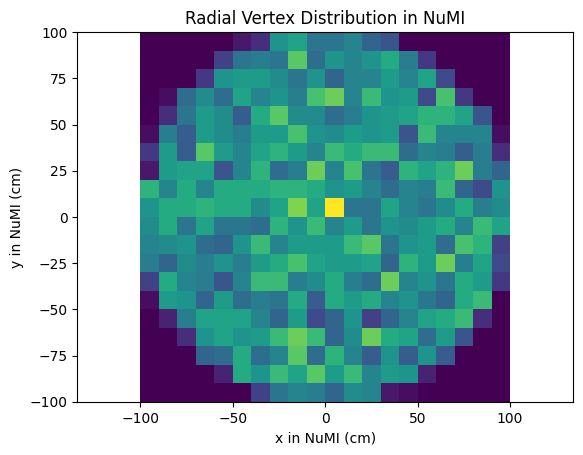

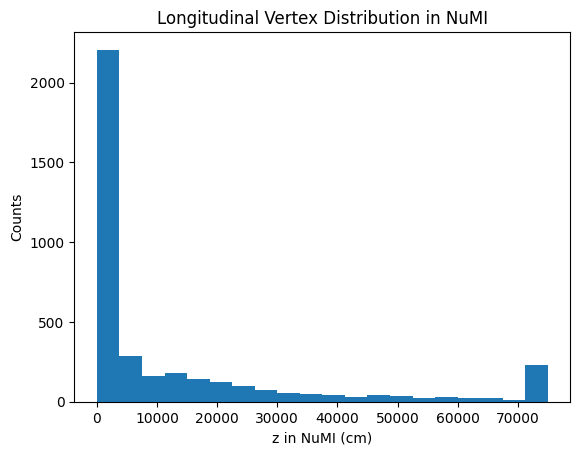

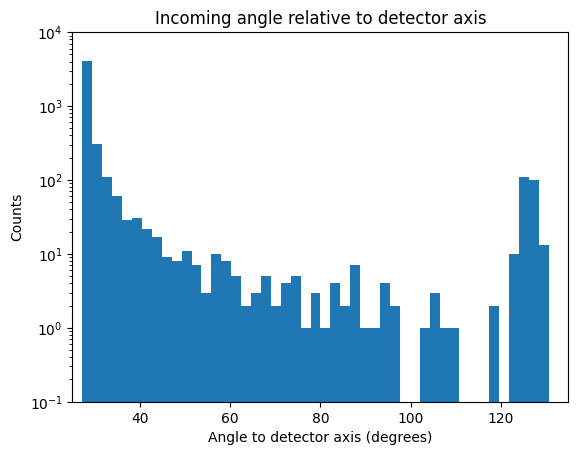

In [104]:
vtx_in_numi_list = []

for vtx in parent_vtx:
    vtx_in_ub = np.array([vtx[0], vtx[1], vtx[2]])

    vtx_in_numi = (ub_to_numi_matrix @ vtx_in_ub) + uboone_in_numi
    vtx_in_numi_list.append(vtx_in_numi)
    # vtx_in_uboone = numi_to_uboone_matrix.dot(vtx_in_numi - uboone_in_numi)
    # print(f'Numi Vertex: {vtx_in_numi}, Uboone Vertex: {vtx_in_uboone}')
vtx_in_numi = np.array(vtx_in_numi_list)
N_bins = 20

plt.hist2d(vtx_in_numi[:,0], vtx_in_numi[:,1], bins=[np.linspace(-100, 100, N_bins+1), np.linspace(-100, 100, N_bins+1)])
plt.xlabel('x in NuMI (cm)')
plt.ylabel('y in NuMI (cm)')
plt.title('Radial Vertex Distribution in NuMI')
plt.axis('equal')
plt.show()

plt.hist(vtx_in_numi[:,2], bins=np.linspace(0, 75000, N_bins+1))
plt.xlabel('z in NuMI (cm)')
plt.ylabel('Counts')
plt.title('Longitudinal Vertex Distribution in NuMI')
plt.show()

det_axis = [0,0,1]
p_vec = parent_p / np.linalg.norm(parent_p, axis=1)[:, np.newaxis]

angles =np.arccos(np.clip(np.dot(p_vec, det_axis), -1.0, 1.0))
angles_deg = np.degrees(angles)

angle_bins = np.linspace(25, 135, 51)

plt.hist(angles_deg, bins=angle_bins)
plt.xlim(angle_bins[0], angle_bins[-1])
plt.xlabel('Angle to detector axis (degrees)')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(1e-1, 1e4)
plt.title('Incoming angle relative to detector axis')
plt.show()

# Parent Distributions

## BNB

/tmp/ipykernel_2492396/792448557.py:39: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



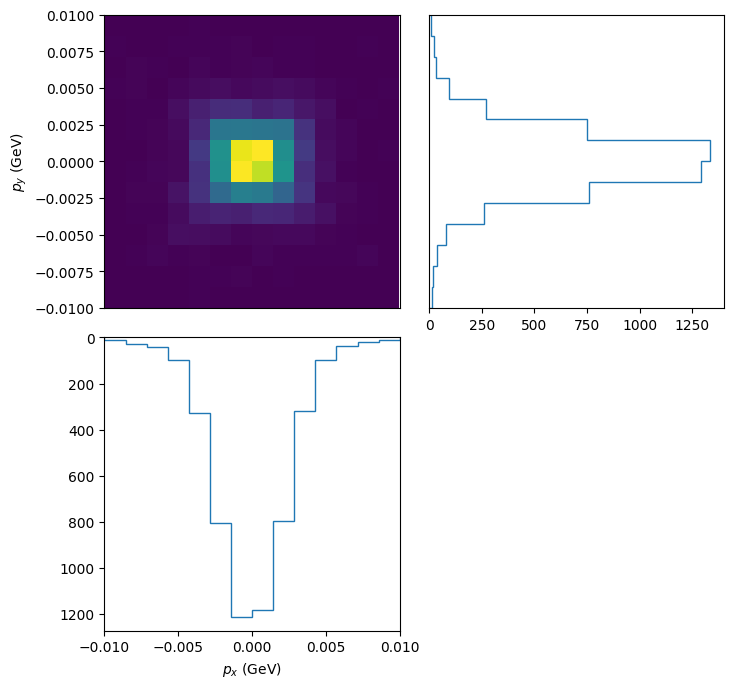

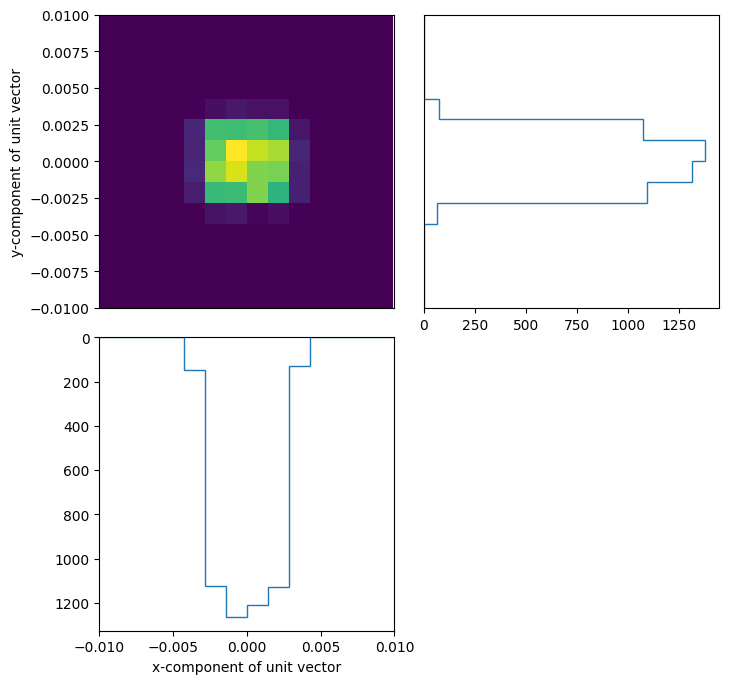

In [140]:
df = hepmc_to_df('outputs/numu_epem_5000.hepmc')
parent_nus = df.query('State >= 3 & PDG != 1000180400')


ref_vec = np.array([0, 0, 1])# z-axis
px, py, pz = parent_nus['px'].values, parent_nus['py'].values, parent_nus['pz'].values
vectors = np.array([[px[i], py[i], pz[i]] for i in range(len(px))])
vectors = np.array(vectors)

vector_norms = np.linalg.norm(vectors, axis=1)
unit_vectors = vectors / vector_norms[:, np.newaxis]

bins = np.linspace(-0.01, 0.01, 15)

fig, ax = plt.subplots(2,2,  sharex=False, sharey=False,figsize = (8,8))
plt.subplots_adjust(hspace=0.1, wspace=0.1)


plt.sca(ax[0,0])
plt.hist2d(vectors[:,0], vectors[:,1], bins=[bins, bins])
plt.xlim(np.min(bins), np.max(bins))
plt.ylim(np.min(bins), np.max(bins))
plt.axis('equal')

plt.ylabel(f'$p_y$ (GeV)')
# plt.colorbar(label='Counts')

plt.sca(ax[1,0])
ax[1,0].yaxis.set_inverted(True)
plt.hist(vectors[:,0], bins=bins, histtype='step', label='x-component')
plt.xlabel(f'$p_x$ (GeV)')
plt.xlim(np.min(bins), np.max(bins))
plt.sca(ax[0,1])
plt.hist(vectors[:,1], bins=bins, histtype='step', label='y-component', orientation='horizontal')
plt.ylim(np.min(bins), np.max(bins))

ax[0,0].get_xaxis().set_visible(False)
ax[0,1].get_yaxis().set_visible(False)
# plt.legend()
# plt.xlabel('Momentum fraction')
# plt.ylabel('Counts')
ax[1,1].axis('off')

plt.show()

fig, ax = plt.subplots(2,2,  sharex=False, sharey=False,figsize = (8,8))
plt.subplots_adjust(hspace=0.1, wspace=0.1)


plt.sca(ax[0,0])
plt.hist2d(unit_vectors[:,0], unit_vectors[:,1], bins=[bins, bins])
plt.xlim(np.min(bins), np.max(bins))
plt.ylim(np.min(bins), np.max(bins))
plt.axis('equal')

plt.ylabel('y-component of unit vector')
# plt.colorbar(label='Counts')

plt.sca(ax[1,0])
ax[1,0].yaxis.set_inverted(True)
plt.hist(unit_vectors[:,0], bins=bins, histtype='step', label='x-component')

plt.xlabel('x-component of unit vector')
plt.xlim(np.min(bins), np.max(bins))
plt.sca(ax[0,1])
plt.hist(unit_vectors[:,1], bins=bins, histtype='step', label='y-component', orientation='horizontal')
plt.ylim(np.min(bins), np.max(bins))

ax[0,0].get_xaxis().set_visible(False)
ax[0,1].get_yaxis().set_visible(False)
# plt.legend()
# plt.xlabel('Momentum fraction')
# plt.ylabel('Counts')
ax[1,1].axis('off')

plt.show()

In [114]:
mean_x, uncert_x = np.mean(vectors[:,0]), np.std(vectors[:,0])
mean_y, uncert_y = np.mean(vectors[:,1]), np.std(vectors[:,1])

print(f'Mean px: {mean_x:.6f} +/- {uncert_x:.6f} GeV')
print(f'Mean py: {mean_y:.6f} +/- {uncert_y:.6f} GeV')

Mean px: -0.000042 +/- 0.002543 GeV
Mean py: 0.000003 +/- 0.002431 GeV


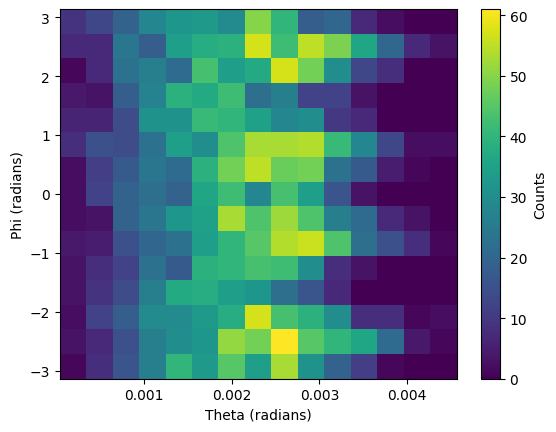

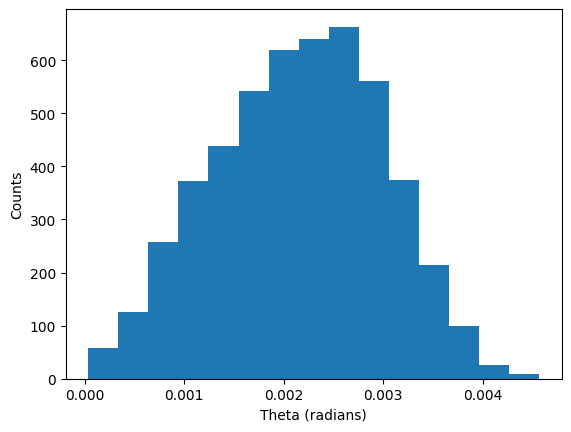

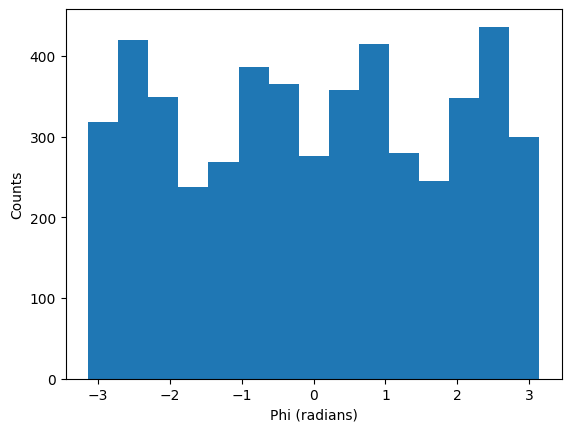

In [115]:
theta = np.arccos(unit_vectors[:,2])
phi = np.arctan2(unit_vectors[:,1], unit_vectors[:,0])

nbins = 15
plt.hist2d(theta, phi, bins=[nbins, nbins], )
plt.xlabel('Theta (radians)')
plt.ylabel('Phi (radians)')
plt.colorbar(label='Counts')
plt.show()

plt.hist(theta, bins=nbins)
plt.xlabel('Theta (radians)')
plt.ylabel('Counts')
plt.show()

plt.hist(phi, bins=nbins)
plt.xlabel('Phi (radians)')
plt.ylabel('Counts')
plt.show()

## NuMI

In [157]:
df = hepevt_to_df('outputs/numu_numi_5000.hepevt')
parent_nus = df.query('State >= 3 & PDG != 1000180400')
vectors = parent_nus[['px', 'py', 'pz']].values
vectors /= np.linalg.norm(vectors, axis=1)[:, np.newaxis]
parent_nus['angle_to_det'] = np.degrees(np.arccos(np.clip(np.dot(vectors, det_axis), -1.0, 1.0)))

bins = np.linspace(0, 5, 51)

/tmp/ipykernel_2492396/792448557.py:74: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/tmp/ipykernel_2492396/2177063455.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



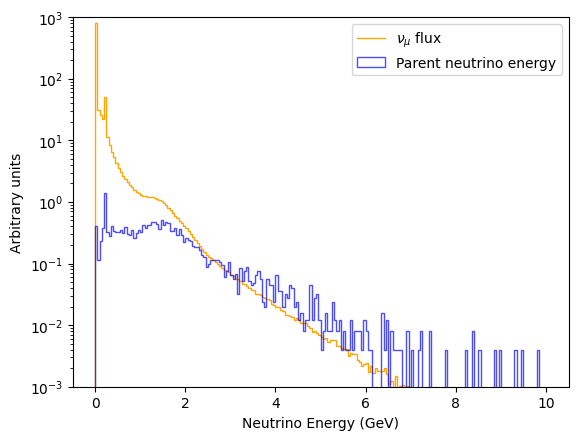

In [167]:
import uproot

nu_flavour = 'numu'
flux_file = 'data/flux/numi/MCC9_FluxHist_volTPCActive_w2D_hists.root'
flux_file = uproot.open(flux_file)

E_hist = flux_file[f'hE{nu_flavour}_cv']
bins_E = E_hist.axis(0).edges() # GeV
E_values = E_hist.values() # N per per cm per POT

plt.stairs(E_values*1000/np.sum(E_values), bins_E, label=r'$\nu_\mu$ flux', color='orange')
plt.hist(parent_nus['E'], bins=bins_E, density=True, histtype='step', label='Parent neutrino energy', color='blue', alpha=0.7)
plt.yscale('log')
plt.xlabel('Neutrino Energy (GeV)') 
plt.ylabel('Arbitrary units')
plt.legend()
plt.ylim(1e-3, 1e3)
plt.show()

/tmp/ipykernel_2492396/792448557.py:74: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/tmp/ipykernel_2492396/34251147.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



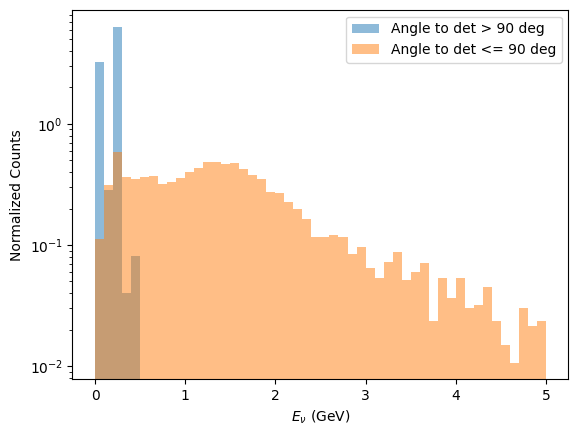

Text(0.5, 0, '$p_y$ (GeV)')

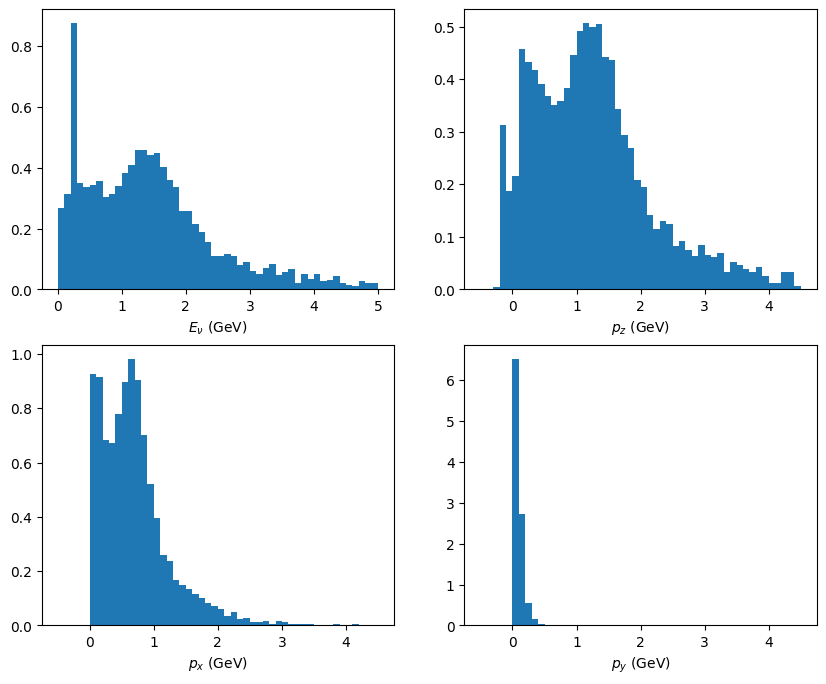

In [153]:
df = hepevt_to_df('outputs/numu_numi_5000.hepevt')
parent_nus = df.query('State >= 3 & PDG != 1000180400')
vectors = parent_nus[['px', 'py', 'pz']].values
vectors /= np.linalg.norm(vectors, axis=1)[:, np.newaxis]
parent_nus['angle_to_det'] = np.degrees(np.arccos(np.clip(np.dot(vectors, det_axis), -1.0, 1.0)))

bins = np.linspace(0, 5, 51)

plt.hist(parent_nus.query('angle_to_det > 90')['E'].values, bins=bins, alpha=0.5, density=True, label='Angle to det > 90 deg')
plt.hist(parent_nus.query('angle_to_det <= 90')['E'].values, bins=bins, alpha=0.5, density=True, label='Angle to det <= 90 deg')
plt.xlabel(r'$E_\nu$ (GeV)')
plt.ylabel('Normalized Counts')
plt.legend()
plt.yscale('log')
plt.show()

fig, ax = plt.subplots(2,2,  sharex=False, sharey=False,figsize = (10,8))

mom_bins = np.linspace(-0.5, 4.5, 51)
plt.sca(ax[0,0])
plt.hist(parent_nus['E'].values, bins=bins, density=True)
plt.xlabel(r'$E_\nu$ (GeV)')
plt.sca(ax[0,1])
plt.hist(parent_nus['pz'].values, bins=mom_bins, density=True)
plt.xlabel(r'$p_z$ (GeV)')
plt.sca(ax[1,0])
plt.hist(parent_nus['px'].values, bins=mom_bins, density=True)
plt.xlabel(r'$p_x$ (GeV)')
plt.sca(ax[1,1])
plt.hist(parent_nus['py'].values, bins=mom_bins, density=True)
plt.xlabel(r'$p_y$ (GeV)')

# Reading Production Vertex Debug

In [ ]:
file = 'production_vertex_temp.txt'
vertex_debug = pd.read_csv(file, delim_whitespace=True, header=3).to_numpy()

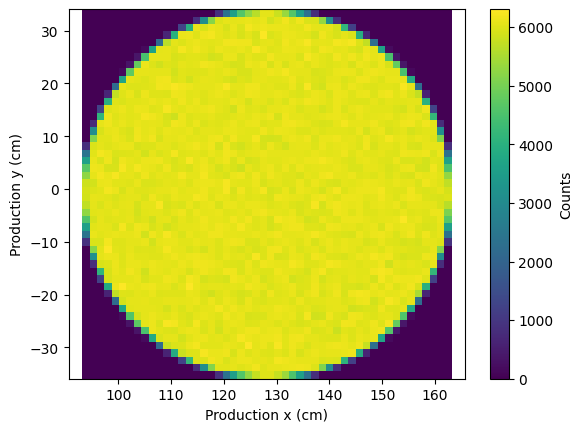

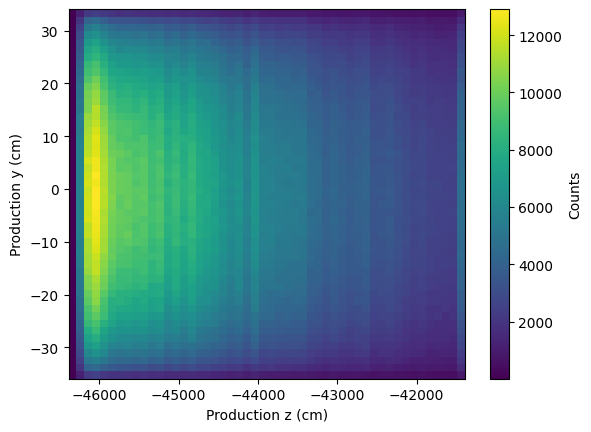

(array([  1166., 227977., 469132., 502102., 450300., 405038., 387641.,
        386103., 374750., 378185., 356706., 366017., 327676., 344125.,
        320648., 338885., 310935., 301519., 288465., 267155., 248543.,
        260447., 228469., 264210., 224697., 222850., 213663., 212131.,
        208746., 206285., 180720., 176301., 160485., 168804., 159148.,
        150563., 156196., 161544., 134993., 136181., 141092., 129252.,
        119982., 109617., 112944., 103551., 101376., 100460.,  98304.,
        179837.]),
 array([-46385.3525, -46285.3925, -46185.4325, -46085.4725, -45985.5125,
        -45885.5525, -45785.5925, -45685.6325, -45585.6725, -45485.7125,
        -45385.7525, -45285.7925, -45185.8325, -45085.8725, -44985.9125,
        -44885.9525, -44785.9925, -44686.0325, -44586.0725, -44486.1125,
        -44386.1525, -44286.1925, -44186.2325, -44086.2725, -43986.3125,
        -43886.3525, -43786.3925, -43686.4325, -43586.4725, -43486.5125,
        -43386.5525, -43286.5925, -43186.6325,

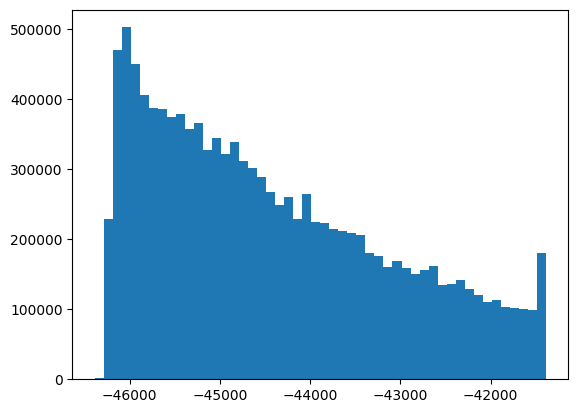

In [ ]:
prod_x,  prod_y,  prod_z = vertex_debug[:,0], vertex_debug[:,1], vertex_debug[:,2]

plt.hist2d(prod_x, prod_y, bins=[50, 50])
plt.xlabel('Production x (cm)')
plt.ylabel('Production y (cm)')
plt.colorbar(label='Counts')
plt.axis('equal')
plt.show()
plt.hist2d(prod_z, prod_y, bins=[50, 50])
plt.xlabel('Production z (cm)')
plt.ylabel('Production y (cm)')
plt.colorbar(label='Counts')
plt.show()

plt.hist(prod_z, bins=50)